In [76]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 23.4 MB/s 


In [80]:
#-----------------------------------------------------Generic imports
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#-----------------------------------------------------Generic imports

#-----------------------------------------------------ANN specific imports
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
#-----------------------------------------------------ANN specific imports

%matplotlib inline

In [2]:
data_path = 'Churn_Modelling.csv'
data = pd.read_csv(data_path,delimiter = ',')
data.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
# Dropping the ireelevant columns
irrelevant_columns = ['Surname','CustomerId','RowNumber']
data_new = data[[i for i in data.columns if not i in irrelevant_columns]]
data_new.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [4]:
# Checking for the missing values
data_new.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

# One-Hot Encoding the geography column

In [5]:
data_new['Geography'].nunique(), sorted(data_new['Geography'].unique())

(3, ['France', 'Germany', 'Spain'])

In [6]:
data_new['Geography']

0        France
1         Spain
2        France
3        France
4         Spain
         ...   
9995     France
9996     France
9997     France
9998    Germany
9999     France
Name: Geography, Length: 10000, dtype: object

In [7]:
ohe_geography = pd.get_dummies(data=data_new['Geography'],prefix='Geography')
ohe_geography.head(3)

,Geography_France,Geography_Germany,Geography_Spain
0,1,0,0
1,0,0,1
2,1,0,0


# One-Hot Encoding the Gender variable

In [8]:
data_new['Gender'].nunique(), sorted(data_new['Gender'].unique())

(2, ['Female', 'Male'])

In [9]:
data_new['Gender']

0       Female
1       Female
2       Female
3       Female
4       Female
         ...  
9995      Male
9996      Male
9997    Female
9998      Male
9999    Female
Name: Gender, Length: 10000, dtype: object

In [10]:
ohe_gender = pd.get_dummies(data_new['Gender'],prefix='Gender')
ohe_gender

,Gender_Female,Gender_Male
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
9995,0,1
9996,0,1
9997,1,0
9998,0,1


# Concatenating the encoded columns

In [11]:
encoded_data = pd.concat((data_new,ohe_geography,ohe_gender), axis = 'columns')
encoded_data.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0


# Dropping the original categorical columns

In [12]:
cat_cols = ['Geography','Gender']
final_data1 = encoded_data.drop(columns = cat_cols)
final_data1.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0


# Verifying the integrity of the continuous columns

In [13]:
# Defining a function to check the integrity of columns
def integrity_checker(dataframe, col_names, bad_value=0):
  for_df = {'ColumnName':[],
            'BadValuesCount':[]}
  for col in col_names:
    cut_df_count = dataframe[dataframe[col]==bad_value].shape[0]
    for_df['ColumnName'].append(col)
    for_df['BadValuesCount'].append(cut_df_count)
  return pd.DataFrame(for_df)

In [14]:
cols_to_check = ['CreditScore','Balance','EstimatedSalary','Age']
cols_integrity = integrity_checker(final_data1,cols_to_check)
cols_integrity

,ColumnName,BadValuesCount
0,CreditScore,0
1,Balance,3617
2,EstimatedSalary,0
3,Age,0


In [15]:
# Converting the 0.0 values in Balance column to nan values
final_data1['Balance'] = np.where(final_data1.Balance==0,np.nan,final_data1.Balance)
final_data1.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,NaN,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0


# Splitting the data to perform imputations

- test data = model evaluate
- train data = model train

- more train data  ==  better performance
- 10000000 : 99% -> train, 1% -> test

In [16]:
target = ['Exited']
features = [i for i in final_data1.columns if not i in target]
train_set, test_set = train_test_split(final_data1,test_size = 0.2,random_state = 11)

train_set.shape, test_set.shape

((8000, 14), (2000, 14))

- `Assuming that the client had treated the null values as 0, trying to fill the null values from Balance using KNNImputer`

In [17]:
# Imputing on the train dataset
knn_imputer_tr,knn_imputer_ts = KNNImputer(),KNNImputer()
train_imputed_data,test_imputed_data = knn_imputer_tr.fit_transform(train_set), knn_imputer_ts.fit_transform(test_set)
train_imputed_data,test_imputed_data = pd.DataFrame(train_imputed_data,columns=train_set.columns), pd.DataFrame(test_imputed_data, columns=test_set.columns)

display(train_imputed_data)
display(test_imputed_data)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,628.0,39.0,8.0,107553.33,1.0,1.0,0.0,117523.41,0.0,0.0,0.0,1.0,1.0,0.0
1,736.0,28.0,2.0,98637.44,2.0,1.0,1.0,117431.10,0.0,0.0,0.0,1.0,1.0,0.0
2,545.0,53.0,5.0,114421.55,1.0,1.0,0.0,180598.28,1.0,0.0,1.0,0.0,0.0,1.0
3,768.0,48.0,3.0,122831.58,1.0,1.0,1.0,24533.89,1.0,0.0,1.0,0.0,0.0,1.0
4,489.0,38.0,5.0,117289.92,1.0,0.0,0.0,85231.88,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,641.0,30.0,2.0,87505.47,2.0,0.0,1.0,7278.57,0.0,1.0,0.0,0.0,0.0,1.0
7996,535.0,38.0,8.0,85982.07,1.0,1.0,0.0,9238.35,0.0,1.0,0.0,0.0,0.0,1.0
7997,625.0,32.0,7.0,106957.28,1.0,1.0,1.0,134794.02,0.0,0.0,0.0,1.0,0.0,1.0
7998,512.0,42.0,9.0,93955.83,2.0,1.0,0.0,14828.54,0.0,0.0,1.0,0.0,0.0,1.0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,526.0,31.0,5.0,145537.210,1.0,1.0,0.0,132404.64,0.0,0.0,1.0,0.0,0.0,1.0
1,598.0,35.0,8.0,114212.600,1.0,1.0,1.0,74322.85,0.0,1.0,0.0,0.0,0.0,1.0
2,542.0,67.0,10.0,129431.360,1.0,0.0,1.0,21343.74,0.0,1.0,0.0,0.0,0.0,1.0
3,594.0,56.0,7.0,111415.440,1.0,1.0,0.0,26215.85,1.0,1.0,0.0,0.0,1.0,0.0
4,520.0,45.0,1.0,123086.390,1.0,1.0,1.0,41042.40,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,661.0,33.0,9.0,133783.288,2.0,1.0,1.0,84174.81,0.0,1.0,0.0,0.0,0.0,1.0
1996,598.0,23.0,6.0,120612.106,2.0,1.0,0.0,153229.19,0.0,0.0,0.0,1.0,1.0,0.0
1997,729.0,29.0,5.0,109676.520,1.0,1.0,1.0,25548.47,0.0,0.0,1.0,0.0,0.0,1.0
1998,661.0,41.0,5.0,28082.950,1.0,1.0,0.0,69586.27,1.0,0.0,0.0,1.0,1.0,0.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


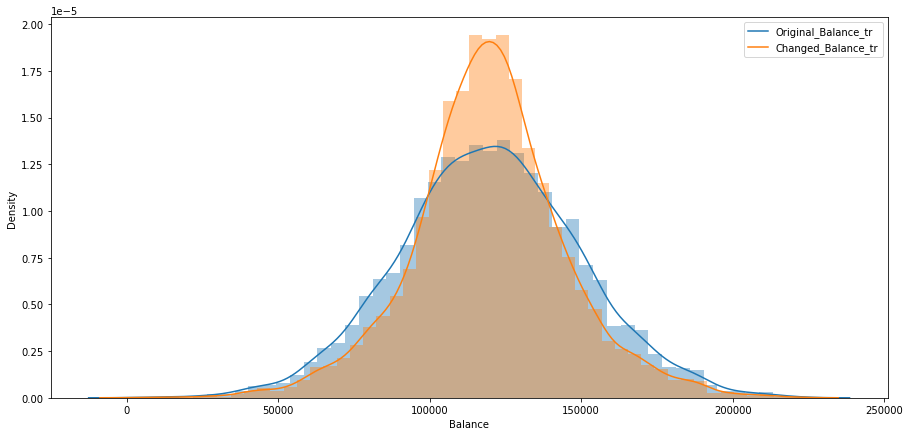

In [18]:
# Visualizing the train imputation
plt.figure(figsize = (15,7))
sns.distplot(train_set.Balance)
sns.distplot(train_imputed_data.Balance)
plt.legend(labels = ['Original_Balance_tr','Changed_Balance_tr'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


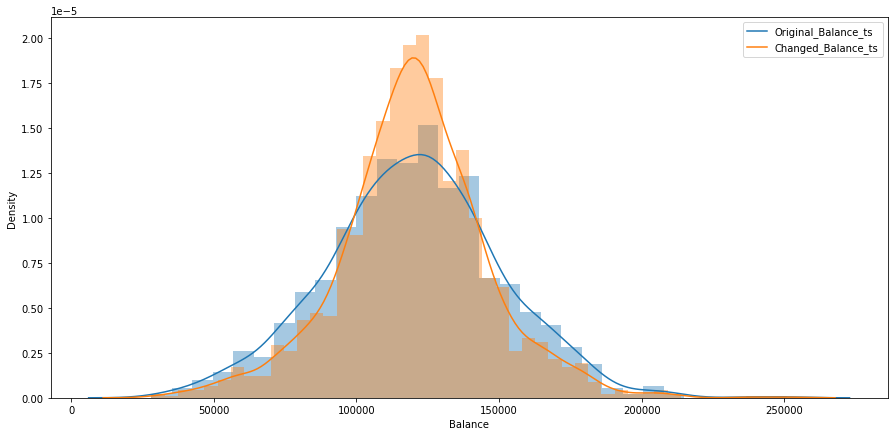

In [19]:
# Visualizing the test imputation
plt.figure(figsize = (15,7))
sns.distplot(test_set.Balance)
sns.distplot(test_imputed_data.Balance)
plt.legend(labels = ['Original_Balance_ts','Changed_Balance_ts'])
plt.show()

# Assuming that the new data is acceptable

In [20]:
test_imputed_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,526.0,31.0,5.0,145537.21,1.0,1.0,0.0,132404.64,0.0,0.0,1.0,0.0,0.0,1.0
1,598.0,35.0,8.0,114212.60,1.0,1.0,1.0,74322.85,0.0,1.0,0.0,0.0,0.0,1.0
2,542.0,67.0,10.0,129431.36,1.0,0.0,1.0,21343.74,0.0,1.0,0.0,0.0,0.0,1.0
3,594.0,56.0,7.0,111415.44,1.0,1.0,0.0,26215.85,1.0,1.0,0.0,0.0,1.0,0.0
4,520.0,45.0,1.0,123086.39,1.0,1.0,1.0,41042.40,1.0,0.0,1.0,0.0,1.0,0.0


In [21]:
for i in test_imputed_data.columns:
  if test_imputed_data[i].nunique()<5:
    print(f'Column name : {i}')
    print(f'Unique values : {sorted(test_imputed_data[i].unique())}')
    print('*'*114)

Column name : NumOfProducts
Unique values : [1.0, 2.0, 3.0, 4.0]
******************************************************************************************************************
Column name : HasCrCard
Unique values : [0.0, 1.0]
******************************************************************************************************************
Column name : IsActiveMember
Unique values : [0.0, 1.0]
******************************************************************************************************************
Column name : Exited
Unique values : [0.0, 1.0]
******************************************************************************************************************
Column name : Geography_France
Unique values : [0.0, 1.0]
******************************************************************************************************************
Column name : Geography_Germany
Unique values : [0.0, 1.0]
****************************************************************************************

# Scaling the data for Neural nets

In [22]:
display(test_imputed_data.head())
display(train_imputed_data.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,526.0,31.0,5.0,145537.21,1.0,1.0,0.0,132404.64,0.0,0.0,1.0,0.0,0.0,1.0
1,598.0,35.0,8.0,114212.60,1.0,1.0,1.0,74322.85,0.0,1.0,0.0,0.0,0.0,1.0
2,542.0,67.0,10.0,129431.36,1.0,0.0,1.0,21343.74,0.0,1.0,0.0,0.0,0.0,1.0
3,594.0,56.0,7.0,111415.44,1.0,1.0,0.0,26215.85,1.0,1.0,0.0,0.0,1.0,0.0
4,520.0,45.0,1.0,123086.39,1.0,1.0,1.0,41042.40,1.0,0.0,1.0,0.0,1.0,0.0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,628.0,39.0,8.0,107553.33,1.0,1.0,0.0,117523.41,0.0,0.0,0.0,1.0,1.0,0.0
1,736.0,28.0,2.0,98637.44,2.0,1.0,1.0,117431.10,0.0,0.0,0.0,1.0,1.0,0.0
2,545.0,53.0,5.0,114421.55,1.0,1.0,0.0,180598.28,1.0,0.0,1.0,0.0,0.0,1.0
3,768.0,48.0,3.0,122831.58,1.0,1.0,1.0,24533.89,1.0,0.0,1.0,0.0,0.0,1.0
4,489.0,38.0,5.0,117289.92,1.0,0.0,0.0,85231.88,0.0,1.0,0.0,0.0,1.0,0.0


## Normalizing the data into train and test split

In [23]:
# Instantiating the scalers
tr_scaler, ts_scaler = MinMaxScaler(),MinMaxScaler()
# Scaling the data
tr_scaled, ts_scaled = tr_scaler.fit_transform(train_imputed_data),ts_scaler.fit_transform(test_imputed_data)
tr_scaled, ts_scaled = pd.DataFrame(tr_scaled, columns = train_imputed_data.columns), pd.DataFrame(ts_scaled,columns=test_imputed_data.columns)

# displaying the scaled data
display(tr_scaled.head())
display(ts_scaled.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.556,0.283784,0.8,0.474989,0.000000,1.0,0.0,0.587679,0.0,0.0,0.0,1.0,1.0,0.0
1,0.772,0.135135,0.2,0.434184,0.333333,1.0,1.0,0.587218,0.0,0.0,0.0,1.0,1.0,0.0
2,0.390,0.472973,0.5,0.506423,0.000000,1.0,0.0,0.903118,1.0,0.0,1.0,0.0,0.0,1.0
3,0.836,0.405405,0.3,0.544913,0.000000,1.0,1.0,0.122637,1.0,0.0,1.0,0.0,0.0,1.0
4,0.278,0.270270,0.5,0.519550,0.000000,0.0,0.0,0.426189,0.0,1.0,0.0,0.0,1.0,0.0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.352,0.213115,0.5,0.527138,0.0,1.0,0.0,0.661885,0.0,0.0,1.0,0.0,0.0,1.0
1,0.496,0.278689,0.8,0.386552,0.0,1.0,1.0,0.371326,0.0,1.0,0.0,0.0,0.0,1.0
2,0.384,0.803279,1.0,0.454854,0.0,0.0,1.0,0.106293,0.0,1.0,0.0,0.0,0.0,1.0
3,0.488,0.622951,0.7,0.373998,0.0,1.0,0.0,0.130666,1.0,1.0,0.0,0.0,1.0,0.0
4,0.340,0.442623,0.1,0.426378,0.0,1.0,1.0,0.204837,1.0,0.0,1.0,0.0,1.0,0.0


In [24]:
# Splitting the features and the target
target_col = ['Exited']

# Splitting the training data
tr_x = tr_scaled.drop(columns = target_col)
tr_y = tr_scaled[target_col]

# Splitting the testing data
ts_x = ts_scaled.drop(columns = target_col)
ts_y = ts_scaled[target_col]

# Building the ANN

### kernel_initializer

- `he` -> regressive activation function  :  `he_uniform`, `he_normal`
- `glorot`  ->  classification activation function  :  `glorot_uniform`, `glorot_normal`

In [45]:
# Instantiating the model
model = tf.keras.Sequential()

# Adding the input layer
model.add(tf.keras.layers.Input(shape=(ts_x.shape[-1],)))

# Adding the 3 - hidden layers
# hidden layer-I
model.add(tf.keras.layers.Dense(units=6,
                                activation='relu', 
                                kernel_initializer = 'he_uniform'))
# hidden layer-II
model.add(tf.keras.layers.Dense(units=12,
                                activation='relu', 
                                kernel_initializer = 'he_uniform'))
# hidden layer-III
model.add(tf.keras.layers.Dense(units=12,
                                activation='relu', 
                                kernel_initializer = 'he_uniform'))

# Adding the output layer
model.add(tf.keras.layers.Dense(units=1,
                                activation='sigmoid',
                                kernel_initializer='glorot_uniform'))


In [46]:
# Compiling the model
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])

In [47]:
# Summarizing the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 6)                 84        
                                                                 
 dense_9 (Dense)             (None, 12)                84        
                                                                 
 dense_10 (Dense)            (None, 12)                156       
                                                                 
 dense_11 (Dense)            (None, 1)                 13        
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Setting configurations
training_batch_size = 32
validation_batch_size = 32

training_steps = tr_x.shape[0]//training_batch_size
validation_steps = ts_x.shape[0]//validation_batch_size

# Training the model
history = model.fit(x=tr_x,
          y=tr_y,
          batch_size=training_batch_size,
          epochs=100,
          validation_data=(ts_x,ts_y),
          steps_per_epoch=training_steps,
          validation_steps=validation_steps,
          validation_batch_size=validation_batch_size,
          workers=10,
          use_multiprocessing=True)

Epoch 1/100
250/250 [==============================] - 2s 6ms/step - loss: 0.5078 - accuracy: 0.7951 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4951 - val_accuracy: 0.8004 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
250/250 [==============================] - 2s 8ms/step - loss: 0.4912 - accuracy: 0.7951 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4851 - val_accuracy: 0.8004 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
250/250 [==============================] - 2s 8ms/step - loss: 0.4829 - accuracy: 0.7951 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4795 - val_accuracy: 0.8004 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
250/250 [==============================] - 2s 7ms/step - loss: 0.4781 - accuracy: 0.7951 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4735 - val_accuracy: 0.8004 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
250/250 [===============

In [54]:
performance_df = pd.DataFrame(history.history)
performance_df.head(3)

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,0.507806,0.795125,0.0,0.0,0.495064,0.800403,0.0,0.0
1,0.491233,0.795125,0.0,0.0,0.485119,0.800403,0.0,0.0
2,0.482900,0.795125,0.0,0.0,0.479477,0.800403,0.0,0.0


In [73]:
def plotter(performance_df,train_metric,epochs):
  val_metric = f'val_{train_metric}'
  plt.figure(figsize=(20,7))
  sns.lineplot(x=epochs,
               y=performance_df[train_metric])
  sns.lineplot(x=epochs,
               y=performance_df[val_metric])
  plt.legend(labels=[train_metric.title(),val_metric.title()])
  plt.xticks(ticks=epochs,labels=epochs,rotation=90)
  print()
  plt.show()

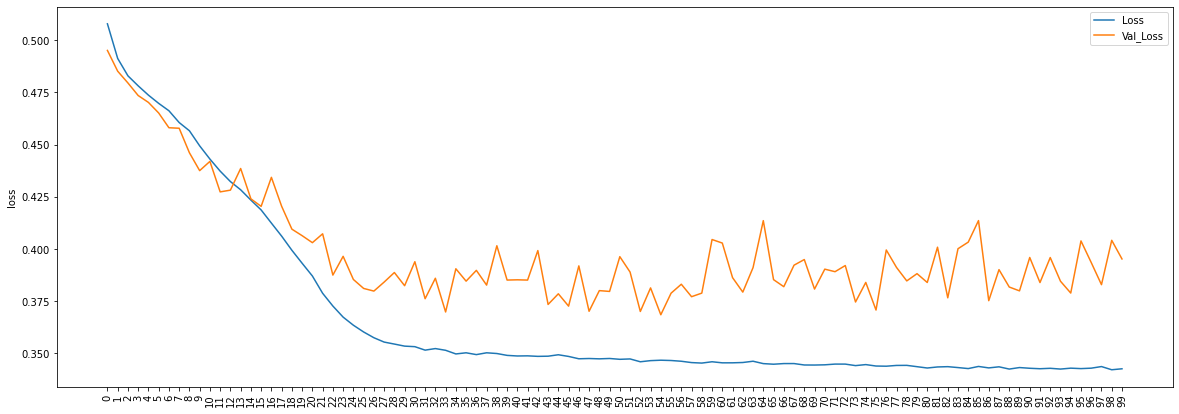

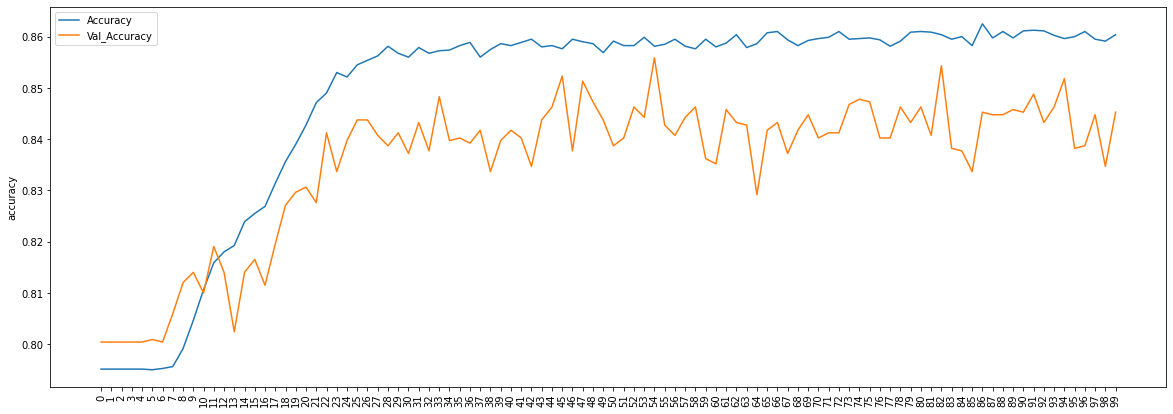

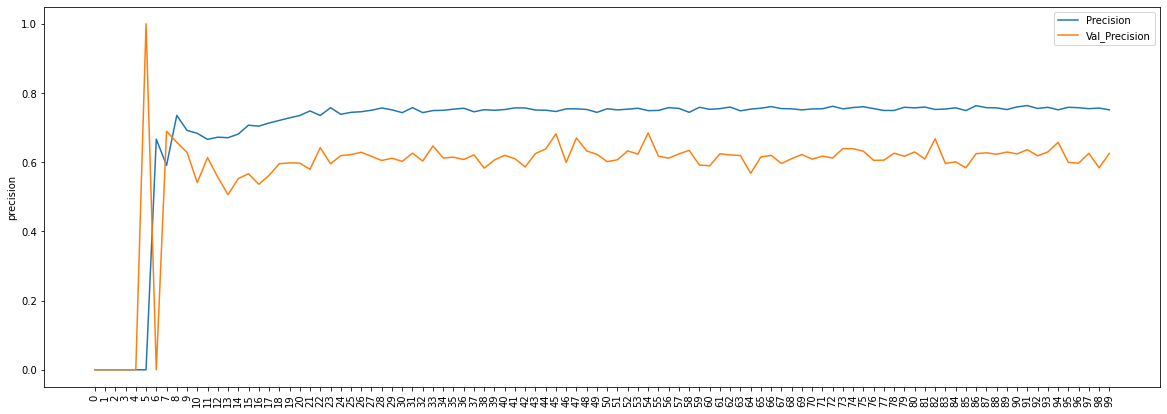

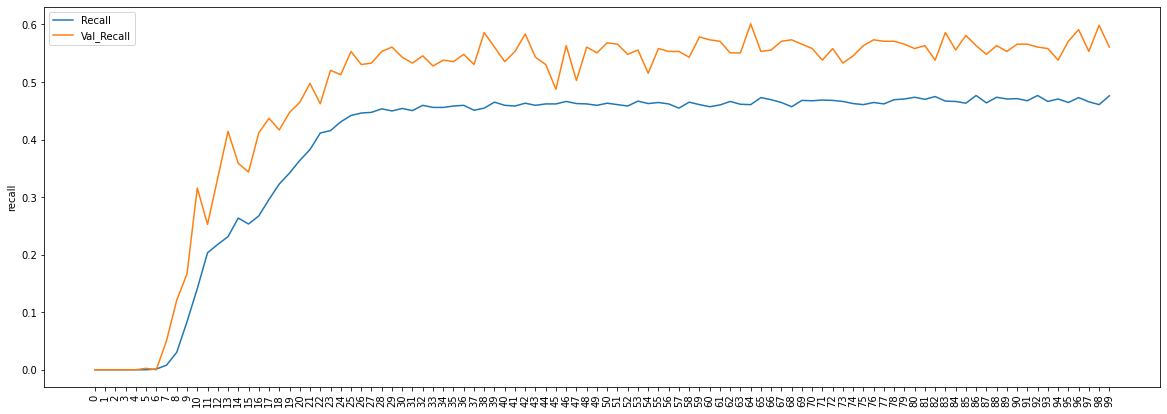

In [74]:
epochs = history.epoch
plotter(performance_df,'loss',epochs)
plotter(performance_df,'accuracy',epochs)
plotter(performance_df,'precision',epochs)
plotter(performance_df,'recall',epochs)

# Hyperparameter tuning of the ann model

- hyp.Int : to iterate over a range of elements
- hyp.Choice : to iterate over a list of elements

- number_of_hidden_layers = range(hyp.Int('number of hidden layers',min_value,max_value,step))
- optimal_initializer = hyp.Choice('kernel initializer',['he_uniform','he_normal','glorot_uniform','glorot_normal'])

In [79]:
# Generating the hypermodel
def model_maker(hyp):
  # -------------------------------------------------Generating the model skeleton
  # instantiating the model
  m = tf.keras.Sequential()

  # Adding the input layer
  m.add(tf.keras.layers.Input((13,)))

  # Adding the hidden layers
  for num_layer in range(hyp.Int('number of hidden layers',min_value=1,max_value=10,step=1)):
    m.add(tf.keras.layers.Dense(units=hyp.Int(f'neurons for layer # {num_layer}',min_value=6,max_value=15,step=3), 
                                activation = hyp.Choice(f'activation for layer # {num_layer}',['sigmoid','relu']), 
                                kernel_initializer = hyp.Choice(f'kernel initializer for layer # {num_layer}',['he_uniform','he_normal','glorot_uniform','glorot_normal'])))

  # Adding the output layer
  m.add(tf.keras.layers.Dense(units=1,activation='sigmoid',kernel_initializer = 'glorot_uniform'))
  # -------------------------------------------------Generating the model skeleton

  # -------------------------------------------------Compiling the model
  m.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy','Precision','Recall'])
  # -------------------------------------------------Compiling the model

  return m

In [81]:
# Creating a tuner object
tuner = RandomSearch(hypermodel=model_maker,
                     objective = 'accuracy')

In [82]:
# Summaizing the tuner object
tuner.search_space_summary()

Search space summary
Default search space size: 4
number of hidden layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
neurons for layer # 0 (Int)
{'default': None, 'conditions': [], 'min_value': 6, 'max_value': 15, 'step': 3, 'sampling': None}
activation for layer # 0 (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'relu'], 'ordered': False}
kernel initializer for layer # 0 (Choice)
{'default': 'he_uniform', 'conditions': [], 'values': ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'], 'ordered': False}


In [83]:
# Finding the best model
tuner.search(tr_x,tr_y, epochs = 50, batch_size = training_batch_size)

Trial 10 Complete [00h 00m 42s]
accuracy: 0.8152499794960022

Best accuracy So Far: 0.8528749942779541
Total elapsed time: 00h 10m 54s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [86]:
# Getting the best model
tuned_model = tuner.get_best_models()[0]

In [88]:
# Summarizing the tuned model
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 84        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 6)                 78        
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 253
Trainable params: 253
Non-trainable params: 0
_________________________________________________________________


In [89]:
# Saving the model

# creating a directory for model weights
model_dir = 'Weights'
os.makedirs(model_dir,exist_ok=True)

# saving the model
tuned_model.save(os.path.join(model_dir,'Best_model_85acc.tf'),save_format='tf')

INFO:tensorflow:Assets written to: Weights/Best_model_85acc.tf/assets


INFO:tensorflow:Assets written to: Weights/Best_model_85acc.tf/assets


In [90]:
# Inoking a saved model

loaded_model = tf.keras.models.load_model(os.path.join(model_dir,'Best_model_85acc.tf'))

In [91]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 84        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 6)                 78        
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 253
Trainable params: 253
Non-trainable params: 0
_________________________________________________________________


# Callbacks elements

In [105]:
class MyCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs = {}):
    if (logs.get('accuracy')>0.84) & (logs.get('val_accuracy')>0.84):
      self.model.stop_training = True
      print()
      print('The accuracy has reached the desired value !')
      print()

In [106]:
callbacks = MyCallbacks()

In [104]:
# Instantiating the model
model1 = tf.keras.Sequential()

# Adding the input layer
model1.add(tf.keras.layers.Input(shape=(ts_x.shape[-1],)))

# Adding the 3 - hidden layers
# hidden layer-I
model1.add(tf.keras.layers.Dense(units=6,
                                activation='relu', 
                                kernel_initializer = 'he_uniform'))
# hidden layer-II
model1.add(tf.keras.layers.Dense(units=12,
                                activation='relu', 
                                kernel_initializer = 'he_uniform'))
# hidden layer-III
model1.add(tf.keras.layers.Dense(units=12,
                                activation='relu', 
                                kernel_initializer = 'he_uniform'))

# Adding the output layer
model1.add(tf.keras.layers.Dense(units=1,
                                activation='sigmoid',
                                kernel_initializer='glorot_uniform'))

# Compiling the model
model1.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])

In [107]:
# Setting configurations
training_batch_size = 32
validation_batch_size = 32

training_steps = tr_x.shape[0]//training_batch_size
validation_steps = ts_x.shape[0]//validation_batch_size

# Training the model
history = model1.fit(x=tr_x,
          y=tr_y,
          batch_size=training_batch_size,
          epochs=100,
          validation_data=(ts_x,ts_y),
          steps_per_epoch=training_steps,
          validation_steps=validation_steps,
          validation_batch_size=validation_batch_size,
          workers=10,
          use_multiprocessing=True,
          callbacks = [callbacks])

Epoch 1/100
250/250 [==============================] - 2s 6ms/step - loss: 0.5126 - accuracy: 0.7951 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4888 - val_accuracy: 0.8004 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
250/250 [==============================] - 1s 4ms/step - loss: 0.4866 - accuracy: 0.7951 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4788 - val_accuracy: 0.8004 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
250/250 [==============================] - 1s 4ms/step - loss: 0.4760 - accuracy: 0.7951 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4752 - val_accuracy: 0.8004 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
250/250 [==============================] - 1s 4ms/step - loss: 0.4690 - accuracy: 0.7951 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4650 - val_accuracy: 0.8004 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
250/250 [===============

In [108]:
from tensorflow.keras.callbacks import EarlyStopping

In [109]:
stopper = EarlyStopping(monitor='accuracy',patience = 5)

In [ ]:
# Training the model
history = model1.fit(x=tr_x,
          y=tr_y,
          batch_size=training_batch_size,s
          epochs=100,
          validation_data=(ts_x,ts_y),
          steps_per_epoch=training_steps,
          validation_steps=validation_steps,
          validation_batch_size=validation_batch_size,
          workers=10,
          use_multiprocessing=True,
          callbacks = [callbacks,stopper])